In [3]:
import numpy as np
import torch
from sympy.utilities.iterables import subsets
from sympy.utilities.iterables import multiset_permutations
import pandas as pd
import gym
device = 'cuda' if torch.cuda.is_available else 'cpu'

#%load_ext line_profiler

In [4]:
def check_almost_align(board, s):
    size = board.shape[0]
    for irow in range(size):
        if board[irow, :].sum() == s * (size - 1):
            i_empty = np.where(board[irow, :] == 0)[0].item()
            return (irow, i_empty)
    for icol in range(size):
        if board[:, icol].sum() == s * (size - 1):
            i_empty = np.where(board[:, icol] == 0)[0].item()
            return (i_empty, icol)
    if np.diag(board).sum() == s * (size - 1):
        i_empty = np.where(np.diag(board) == 0)[0].item()
        return (i_empty, i_empty)
    if np.diag(np.rot90(board)).sum() == s * (size - 1):
        for i in range(size):
            if board[i, size - 1 - i] == 0:
                return (i, size - 1 - i)
    return None

def random_policy(board, symbol):
    available_pos = np.array(np.where(game.board == 0)).T
    pos = np.random.randint(available_pos.shape[0])
    return tuple(available_pos[np.random.randint(available_pos.shape[0])])

def linear_policy(board, symbol):
    available_pos = np.array(np.where(game.board == 0)).T
    return tuple(available_pos[0])

def advanced_static_policy(board, symbol):
    coords = check_almost_align(board, symbol)
    if coords is not None:
        return coords
    coords = check_almost_align(board, -symbol)
    if coords is not None:
        return coords
    available_pos = np.array(np.where(game.board == 0)).T
    return tuple(available_pos[0])

def advanced_random_policy(board, symbol):
    coords = check_almost_align(board, symbol)
    if coords is not None:
        return coords
    coords = check_almost_align(board, -symbol)
    if coords is not None:
        return coords
    available_pos = np.array(np.where(game.board == 0)).T
    return tuple(available_pos[np.random.randint(available_pos.shape[0])])

In [5]:
def sarsa(game, agent, opponent_policy, alpha, alpha_factor, gamma, epsilon, epsilon_factor,
          r_win, r_lose, r_even, r_even2, num_episodes):
    for episode_index in range(num_episodes):
        if episode_index % 1000 == 0:
            print('.', end='')
        alpha *= alpha_factor
        epsilon *= epsilon_factor
        state = game.reset()
        if episode_index%2 == 1:
            action = opponent_policy(state, game.turn)
            state, _, _, _ = game.step(action)
        action = agent.epsilon_greedy_policy(state, epsilon)
        state_history = [state.copy()]
        action_history = [action]
        while True:
            ################### The agent ignores this happens UNLESS it ends the game
            intermediate_state, reward, done, _ = game.step(action)
            if done:
                if reward > 0:
                    final_reward = r_win
                else:
                    final_reward = r_even
                break
            intermediate_action = opponent_policy(intermediate_state, game.turn)
            ################### ------------------------------------------------
            state, reward, done, _ = game.step(intermediate_action)
            if done:
                if reward > 0:
                    reward = r_lose
                else:
                    reward = r_even2
                break
            action = agent.epsilon_greedy_policy(state, epsilon)
            state_history.append(state.copy())
            action_history.append(action)
            
        agent.update_Qtable(state_history, action_history, reward, alpha, gamma)

In [6]:
class Agent:
    
    def __init__(self, size=3, policy=None):
        self.q_array = pd.DataFrame(columns=[str(i)+str(j) for i in range(size) for j in range(size)])
        self.policy = policy
        self.identity = {}
        self.convert_rot90_1 = {}
        self.convert_rot90_2 = {}
        self.convert_rot90_3 = {}
        self.convert_horizontal_axis = {}
        self.convert_vertical_axis = {}
        self.convert_diag = {}
        self.convert_antidiag = {}
        empty = np.zeros([size]*2, dtype=int)
        
        for i in range(empty.shape[0]):
            for j in range(empty.shape[0]):
                empty *= 0
                empty[i, j] = 1
                tr_empty = empty
                coords_transform = tuple(np.argwhere(tr_empty == 1)[0])
                self.identity[str(i)+str(j)] = coords_transform
        
        for i in range(empty.shape[0]):
            for j in range(empty.shape[0]):
                empty *= 0
                empty[i, j] = 1
                tr_empty = np.rot90(empty, 1)
                coords_transform = tuple(np.argwhere(tr_empty == 1)[0])
                self.convert_rot90_1[str(i)+str(j)] = coords_transform
        
        for i in range(empty.shape[0]):
            for j in range(empty.shape[0]):
                empty *= 0
                empty[i, j] = 1
                tr_empty = np.rot90(empty, 2)
                coords_transform = tuple(np.argwhere(tr_empty == 1)[0])
                self.convert_rot90_2[str(i)+str(j)] = coords_transform
                
        for i in range(empty.shape[0]):
            for j in range(empty.shape[0]):
                empty *= 0
                empty[i, j] = 1
                tr_empty = np.rot90(empty, 3)
                coords_transform = tuple(np.argwhere(tr_empty == 1)[0])
                self.convert_rot90_3[str(i)+str(j)] = coords_transform
                
        for i in range(empty.shape[0]):
            for j in range(empty.shape[0]):
                empty *= 0
                empty[i, j] = 1
                tr_empty = empty[::-1]
                coords_transform = tuple(np.argwhere(tr_empty == 1)[0])
                self.convert_horizontal_axis[str(i)+str(j)] = coords_transform
        
        for i in range(empty.shape[0]):
            for j in range(empty.shape[0]):
                empty *= 0
                empty[i, j] = 1
                tr_empty = empty[:, ::-1]
                coords_transform = tuple(np.argwhere(tr_empty == 1)[0])
                self.convert_vertical_axis[str(i)+str(j)] = coords_transform
        
        for i in range(empty.shape[0]):
            for j in range(empty.shape[0]):
                empty *= 0
                empty[i, j] = 1
                tr_empty = empty.T
                coords_transform = tuple(np.argwhere(tr_empty == 1)[0])
                self.convert_diag[str(i)+str(j)] = coords_transform
                
        for i in range(empty.shape[0]):
            for j in range(empty.shape[0]):
                empty *= 0
                empty[i, j] = 1
                tr_empty = np.rot90(empty, 2).T
                coords_transform = tuple(np.argwhere(tr_empty == 1)[0])
                self.convert_antidiag[str(i)+str(j)] = coords_transform
                
    
    def update_Qtable(self, state_history, action_history, reward, alpha, gamma): 
        code_last_state, code_last_action = self.encode_state_and_action(state_history[-1], action_history[-1])
        try:
            self.q_array.loc[code_last_state]
        except:
            self.q_array.loc[code_last_state] = 0.5
        self.q_array.loc[code_last_state, code_last_action] = reward
        
        for i in range(len(state_history)-2, -1, -1):
            state = state_history[i]
            new_state = state_history[i+1]
            action = action_history[i]
            new_action = action_history[i+1]
            code_state, code_action = self.encode_state_and_action(state, action)
            try:
                self.q_array.loc[code_state]
            except:
                self.q_array.loc[code_state] = 0.5
            code_new_state, code_new_action = self.encode_state_and_action(new_state, new_action)
            self.q_array.loc[code_state, code_action] = (1 - alpha) * self.q_array.loc[code_state, code_action] \
                                                        + alpha * gamma * self.q_array.loc[code_new_state, code_new_action]
    
    def play_vs_opponent(self, state, symbol):
        if self.policy is not None:
            return self.policy(state, symbol)
        state_code = self.encode_state(state)
        try:
            self.q_array.loc[state_code]
        except:
            legal_moves = np.argwhere(state == 0)
            return tuple(legal_moves[np.random.randint(legal_moves.shape[0])])
        ###### Find best move
        potential_actions = self.q_array.loc[state_code]
        reference_state = self.decode_one_state(state_code)
        free_spots_scores = []
        
        if np.prod(state == reference_state):
            for a in potential_actions.index:
                tr_coords = self.identity[a]
                if state[tr_coords] == 0:
                    free_spots_scores.append((tr_coords, potential_actions.loc[a]))
        
        elif np.prod(state == np.rot90(reference_state, 1)):
            for a in potential_actions.index:
                tr_coords = self.convert_rot90_1[a]
                if state[tr_coords] == 0:
                    free_spots_scores.append((tr_coords, potential_actions.loc[a]))
        
        elif np.prod(state == np.rot90(reference_state, 2)):
            for a in potential_actions.index:
                tr_coords = self.convert_rot90_2[a]
                if state[tr_coords] == 0:
                    free_spots_scores.append((tr_coords, potential_actions.loc[a]))
        
        elif np.prod(state == np.rot90(reference_state, 3)):
            for a in potential_actions.index:
                tr_coords = self.convert_rot90_3[a]
                if state[tr_coords] == 0:
                    free_spots_scores.append((tr_coords, potential_actions.loc[a]))
        
        elif np.prod(state == reference_state[::-1]):
            for a in potential_actions.index:
                tr_coords = self.convert_horizontal_axis[a]
                if state[tr_coords] == 0:
                    free_spots_scores.append((tr_coords, potential_actions.loc[a]))
        
        elif np.prod(state == reference_state[:, ::-1]):
            for a in potential_actions.index:
                tr_coords = self.convert_vertical_axis[a]
                if state[tr_coords] == 0:
                    free_spots_scores.append((tr_coords, potential_actions.loc[a]))
        
        elif np.prod(state == reference_state.T):
            for a in potential_actions.index:
                tr_coords = self.convert_diag[a]
                if state[tr_coords] == 0:
                    free_spots_scores.append((tr_coords, potential_actions.loc[a]))
        
        elif np.prod(state == np.rot90(reference_state, 2).T):
            for a in potential_actions.index:
                tr_coords = self.convert_antidiag[a]
                if state[tr_coords] == 0:
                    free_spots_scores.append((tr_coords, potential_actions.loc[a]))
        else:
            print('Error in play_vs_opponent in Agent !!!')
        max_reward = max(free_spots_scores, key=lambda x: x[1])[1]
        best_actions = [act for act, rew in free_spots_scores if rew == max_reward]
        return best_actions[np.random.randint(len(best_actions))]
        
    def greedy_policy(self, state):
        """
        Return the next action as a tuple
        """
        code_state = self.encode_state(state)
        try:
            self.q_array.loc[code_state]
        except:
            self.q_array.loc[code_state] = 0.5
        reference_state = self.decode_one_state(code_state)
        legal_actions = []
        actions = self.q_array.loc[code_state]
            
        if np.prod(state == reference_state):
            for act in actions.index:
                coords_transform = self.identity[act]
                if state[coords_transform] == 0:
                    legal_actions.append((coords_transform, actions.loc[act]))
            max_reward = max(legal_actions, key=lambda x: x[1])[1]
            best_actions = [act_rew[0] for act_rew in legal_actions if act_rew[1] == max_reward]
            return best_actions[np.random.randint(len(best_actions))]
        
        if np.prod(state == np.rot90(reference_state, 1)):
            for act in actions.index:
                coords_transform = self.convert_rot90_1[act]
                if state[coords_transform] == 0:
                    legal_actions.append((coords_transform, actions.loc[act]))
            max_reward = max(legal_actions, key=lambda x: x[1])[1]
            best_actions = [act_rew[0] for act_rew in legal_actions if act_rew[1] == max_reward]
            return best_actions[np.random.randint(len(best_actions))]
        
        if np.prod(state == np.rot90(reference_state, 2)):
            for act in actions.index:
                coords_transform = self.convert_rot90_2[act]
                if state[coords_transform] == 0:
                    legal_actions.append((coords_transform, actions.loc[act]))
            max_reward = max(legal_actions, key=lambda x: x[1])[1]
            best_actions = [act_rew[0] for act_rew in legal_actions if act_rew[1] == max_reward]
            return best_actions[np.random.randint(len(best_actions))]
        
        if np.prod(state == np.rot90(reference_state, 3)):
            for act in actions.index:
                coords_transform = self.convert_rot90_3[act]
                if state[coords_transform] == 0:
                    legal_actions.append((coords_transform, actions.loc[act]))
            max_reward = max(legal_actions, key=lambda x: x[1])[1]
            best_actions = [act_rew[0] for act_rew in legal_actions if act_rew[1] == max_reward]
            return best_actions[np.random.randint(len(best_actions))]
        
        if np.prod(state == reference_state[::-1]):
            for act in actions.index:
                coords_transform = self.convert_horizontal_axis[act]
                if state[coords_transform] == 0:
                    legal_actions.append((coords_transform, actions.loc[act]))
            max_reward = max(legal_actions, key=lambda x: x[1])[1]
            best_actions = [act_rew[0] for act_rew in legal_actions if act_rew[1] == max_reward]
            return best_actions[np.random.randint(len(best_actions))]
        
        if np.prod(state == reference_state[:, ::-1]):
            for act in actions.index:
                coords_transform = self.convert_vertical_axis[act]
                if state[coords_transform] == 0:
                    legal_actions.append((coords_transform, actions.loc[act]))
            max_reward = max(legal_actions, key=lambda x: x[1])[1]
            best_actions = [act_rew[0] for act_rew in legal_actions if act_rew[1] == max_reward]
            return best_actions[np.random.randint(len(best_actions))]
        
        if np.prod(state == reference_state.T):
            for act in actions.index:
                coords_transform = self.convert_diag[act]
                if state[coords_transform] == 0:
                    legal_actions.append((coords_transform, actions.loc[act]))
            max_reward = max(legal_actions, key=lambda x: x[1])[1]
            best_actions = [act_rew[0] for act_rew in legal_actions if act_rew[1] == max_reward]
            return best_actions[np.random.randint(len(best_actions))]
        
        if np.prod(state == np.rot90(reference_state, 2).T):
            for act in actions.index:
                coords_transform = self.convert_antidiag[act]
                if state[coords_transform] == 0:
                    legal_actions.append((coords_transform, actions.loc[act]))
            max_reward = max(legal_actions, key=lambda x: x[1])[1]
            best_actions = [act_rew[0] for act_rew in legal_actions if act_rew[1] == max_reward]
            return best_actions[np.random.randint(len(best_actions))]
        print('\nError in greedy policy !!!\n')
        print(state, '\n')
        print(reference_state, '\n')
        print(reference_state[::-1][::-1].T)

    def epsilon_greedy_policy(self, state, epsilon):
        """
        Return the next action as a tuple
        """
        if self.q_array.empty or np.random.rand() < epsilon:
            legal_moves = np.argwhere(state == 0)
            size = legal_moves.shape[0]
            random_idx = np.random.randint(size)
            action = tuple(legal_moves[random_idx])
        else:
            action = self.greedy_policy(state)
        return action
    
    def encode_action(self, action):
        if type(action) is str:
            return action
        code_action = ''
        for i in action:
            code_action += str(i)
        return code_action

    def decode_action(self, code_action):
        return tuple([int(i) for i in code_action])

    def encode_one_state(self, state):
        code_state = ''
        for i in state.flatten():
            code_state += str(i) if i != -1 else '2'
        return code_state

    def generate_all_sym_states(self, state):
        sym_states = [self.encode_one_state(state), self.encode_one_state(np.rot90(state, 1)),
                      self.encode_one_state(np.rot90(state, 2)), self.encode_one_state(np.rot90(state, 3)),
                      self.encode_one_state(state[::-1]), self.encode_one_state(state[:, ::-1]),
                      self.encode_one_state(state.T), self.encode_one_state(np.rot90(state, 2).T)]
        sym_states.sort()
        return sym_states
    
    def encode_state_and_action(self, state, action):
        empty_state = state * 0
        empty_state[action] = 1
        sym = [(self.encode_one_state(state), tuple(np.argwhere(empty_state == 1)[0])),
               (self.encode_one_state(np.rot90(state, 1)), tuple(np.argwhere(np.rot90(empty_state, 1) == 1)[0])),
               (self.encode_one_state(np.rot90(state, 2)), tuple(np.argwhere(np.rot90(empty_state, 2) == 1)[0])),
               (self.encode_one_state(np.rot90(state, 3)), tuple(np.argwhere(np.rot90(empty_state, 3) == 1)[0])),
               (self.encode_one_state(state[::-1]), tuple(np.argwhere(empty_state[::-1] == 1)[0])),
               (self.encode_one_state(state[:, ::-1]), tuple(np.argwhere(empty_state[:, ::-1] == 1)[0])),
               (self.encode_one_state(state.T), tuple(np.argwhere(empty_state.T == 1)[0])),
               (self.encode_one_state(np.rot90(state, 2).T), tuple(np.argwhere(np.rot90(empty_state, 2).T == 1)[0]))]
        sym.sort(key=lambda x: x[0])
        code_state = sym[0][0]
        tr_action = sym[0][1]
        code_action = self.encode_action(tr_action)
        return code_state, code_action

    def encode_state(self, state):
        sym_states = self.generate_all_sym_states(state)
        return sym_states[0]
    
    def decode_one_state(self, code_state):
        flat_list = [0 if elem == '0' else 1 if elem == '1' else -1 for elem in list(code_state)]
        size = int(np.sqrt(len(code_state)))
        state = np.reshape(flat_list, (size, size))
        return state

In [60]:
import gym
class Game(gym.Env):
    
    def __init__(self, p1, p2, size=3, n_dim=2):
        assert(type(n_dim) is int and n_dim >= 2), "wrong n_dim"
        assert(type(size) is int and size >= 2), "wrong size"
        self.n_dim = n_dim
        self.size = size
        self.p1 = p1
        self.p2 = p2
        self.turn = 1
        self.board = np.zeros([size]*n_dim, dtype=int)
        self.current_score = (0, 0)
        self._max_episode_steps = 1000
        super(Game, self).__init__()
    
    def simulate_games(self, n=100):
        win_p1, win_p2, tot_even = 0, 0, 0
        for _ in range(n // 2):
            s1, s2 = self.play_a_game(verbose=False)
            if s1 > s2:
                win_p1 += 1
            elif s2 > s1:
                win_p2 += 1
            else:
                tot_even += 1
        self.p1, self.p2 = self.p2, self.p1
        for _ in range(n // 2):
            s1, s2 = self.play_a_game(verbose=False)
            if s1 > s2:
                win_p2 += 1
            elif s2 > s1:
                win_p1 += 1
            else:
                tot_even += 1
        self.p1, self.p2 = self.p2, self.p1
        return win_p1, win_p2, tot_even
    
    def play_a_game(self, verbose=True):
        self.reset()
        if verbose:
            self.render()
        digits = '1234567890'
        while not self.is_done():
            if self.turn == 1:
                player = self.p1
            else:
                player = self.p2
            if isinstance(player, Agent):
                coords = player.play_vs_opponent(self.board, self.turn)
                if verbose:
                    print('Agent plays :', coords, '\n')
            else:
                coords_str = input('Coordinates of next move : ')
                print()
                coords = []
                for c in coords_str:
                    if c in digits:
                        coords.append(int(c))
                coords = tuple(coords)
                while len(coords) != self.n_dim or max(coords) >= self.size or not self.is_available(coords):
                    coords_str = input('Position not available, please try another one : ')
                    coords = []
                    for c in coords_str:
                        if c in digits:
                            coords.append(int(c))
                    coords = tuple(coords)
            self.step(coords)
            if verbose:
                self.render()
        if verbose:
            print('Game over. Score :', self.current_score)
            if self.current_score[0] > self.current_score[1]:
                print(self.p1, 'wins !')
            elif self.current_score[1] > self.current_score[0]:
                print(self.p2, 'wins !')
            else:
                print('Even score.')
        return self.current_score
    
    def is_available(self, position):
        return self.board[position] == 0
    
    def is_done(self):
        if self.n_dim == 2:
            return sum(self.current_score) != 0 or 0 not in self.board
        return 0 not in self.board
    
    def reset(self):
        self.turn = 1
        self.current_score = (0, 0)
        self.board *= 0
        return self.board.copy()

    def step(self, position):
        self.board[position] = self.turn
        score_p1, score_p2 = self.score()
        score_p1_diff, score_p2_diff =  score_p1 - self.current_score[0], score_p2 - self.current_score[1]
        # update only the score of the player that did the latest move
        if self.turn == 1:
            self.current_score = (score_p1, self.current_score[1])
        else:
            self.current_score = (self.current_score[0], score_p2)
        reward = score_p1_diff if self.turn == 1 else score_p2_diff
        self.turn *= -1
        return self.board, reward, self.is_done(), None             
    
    def render(self):
        visual_board = self.board.copy()
        visual_board = np.where(visual_board == -1, 'O', visual_board)
        visual_board = np.where(visual_board == '1', 'X', visual_board)
        visual_board = np.where(visual_board == '0', '.', visual_board)
        for icol in range(self.size):
            for row in visual_board[icol, :]:
                print(row, end=' ')
            print()
        print()
    
    def score(self):
        score_p1 = 0
        score_p2 = 0
        
        def slice_to_mask(L):
            """
            Enables to use slicing operator like array[x, y, :, z] with choosing the position
            of the symbol ':' (represented with a -1 instead). For example L can be equal to
            [0, 0, -1, 0] if we want to access self.board[0, 0, :, 0]
            """
            mask = np.zeros([self.size] * self.n_dim, dtype=bool)
            dim = L.index(-1)
            for tile in range(self.size):
                L[dim] = tile
                mask[tuple(L)] = True
            return mask
        
        # vertical and horizontal axis
        all_axis = []
        for d in range(self.size ** self.n_dim):
            all_axis.append([(d // self.size**k) % self.size for k in range(self.n_dim)[::-1]])
            # example in 3D case with size 3 :
            # all_axis = [ [i, j, k] for i = 0, 1, 2 for j = 0, 1, 2 for k = 0, 1, 2 ]
        for d in range(self.n_dim):
            d_axis = np.array(all_axis)
            d_axis[:, d] = -1
            d_axis = np.unique(d_axis, axis=0)
            for axis in d_axis:
                space_mask = slice_to_mask(list(axis))
                in_game_axis = self.board[space_mask]
                axis_value = in_game_axis.sum().item()
                if axis_value == self.size:
                    score_p1 += 1
                elif axis_value == -self.size:
                    score_p2 += 1
        
        # diagonal axis
        diag = np.array([range(self.size)]).T
        antidiag = np.array([range(self.size-1, -1, -1)]).T
        poss_diag = np.array([diag, antidiag])
        poss_index = list(range(self.size))
        coords_to_check = set()
        for dof in range(self.n_dim-2, -1, -1):
            dof_fc = self.n_dim - dof
            cpt = 0
            for fc in subsets(poss_diag, dof_fc, repetition=True):
                if cpt == int(dof_fc / 2) + 1:
                    break
                cpt += 1
                frozen_comp = np.array(fc).reshape((dof_fc, self.size)).T
                if dof > 0:
                    for free_comp in subsets(poss_index, dof, repetition=True):
                        free_comp_array = np.repeat(np.array([free_comp]), self.size, axis=0)
                        coords = np.hstack((free_comp_array, frozen_comp))
                        for perm in multiset_permutations(coords.T.tolist()):
                            perm_coords = [list(i) for i in zip(*perm)]
                            perm_coords.sort()
                            coords_to_check.add(tuple(map(tuple, perm_coords)))
                else:
                    coords = frozen_comp
                    for perm in multiset_permutations(coords.T.tolist()):
                        perm_coords = [list(i) for i in zip(*perm)]
                        perm_coords.sort()
                        coords_to_check.add(tuple(map(tuple, perm_coords)))
                        
        for coords in coords_to_check:
            total = 0
            for tile in coords:
                total += self.board[tile]
            if abs(total) == self.size:
                if total > 0:
                    score_p1 += 1
                else:
                    score_p2 += 1
                
        return score_p1, score_p2
    
    def almost_align(self):
        
        def slice_to_mask(L):
            """
            Enables to use slicing operator like array[x, y, :, z] with choosing the position
            of the symbol ':' (represented with a -1 instead). For example L can be equal to
            [0, 0, -1, 0] if we want to access self.board[0, 0, :, 0]
            """
            mask = np.zeros([self.size] * self.n_dim, dtype=bool)
            dim = L.index(-1)
            for tile in range(self.size):
                L[dim] = tile
                mask[tuple(L)] = True
            return mask
        
        score_p1 = 0
        score_p2 = 0
        # vertical and horizontal axis
        all_axis = []
        for d in range(self.size ** self.n_dim):
            all_axis.append([(d // self.size**k) % self.size for k in range(self.n_dim)[::-1]])
            # example in 3D case with size 3 :
            # all_axis = [ [i, j, k] for i = 0, 1, 2 for j = 0, 1, 2 for k = 0, 1, 2 ]
        for d in range(self.n_dim):
            d_axis = np.array(all_axis)
            d_axis[:, d] = -1
            d_axis = np.unique(d_axis, axis=0)
            for axis in d_axis:
                space_mask = slice_to_mask(list(axis))
                in_game_axis = self.board[space_mask]
                axis_value = in_game_axis.sum().item()
                if axis_value == self.size - 1:
                    score_p1 += 1
                elif axis_value == -self.size + 1:
                    score_p2 += 1
        
        # diagonal axis
        diag = np.array([range(self.size)]).T
        antidiag = np.array([range(self.size-1, -1, -1)]).T
        poss_diag = np.array([diag, antidiag])
        poss_index = list(range(self.size))
        coords_to_check = set()
        for dof in range(self.n_dim-2, -1, -1):
            dof_fc = self.n_dim - dof
            cpt = 0
            for fc in subsets(poss_diag, dof_fc, repetition=True):
                if cpt == int(dof_fc / 2) + 1:
                    break
                cpt += 1
                frozen_comp = np.array(fc).reshape((dof_fc, self.size)).T
                if dof > 0:
                    for free_comp in subsets(poss_index, dof, repetition=True):
                        free_comp_array = np.repeat(np.array([free_comp]), self.size, axis=0)
                        coords = np.hstack((free_comp_array, frozen_comp))
                        for perm in multiset_permutations(coords.T.tolist()):
                            perm_coords = [list(i) for i in zip(*perm)]
                            perm_coords.sort()
                            coords_to_check.add(tuple(map(tuple, perm_coords)))
                else:
                    coords = frozen_comp
                    for perm in multiset_permutations(coords.T.tolist()):
                        perm_coords = [list(i) for i in zip(*perm)]
                        perm_coords.sort()
                        coords_to_check.add(tuple(map(tuple, perm_coords)))
                        
        for coords in coords_to_check:
            total = 0
            for tile in coords:
                total += self.board[tile]
            if abs(total) == self.size - 1:
                if total > 0:
                    score_p1 += 1
                else:
                    score_p2 += 1
                
        return score_p1, score_p2

    def board_position_to_tuple(self, pos):
        resulting_position = []
        for k in range(self.n_dim):
            resulting_position.append(pos % self.size)
            pos //= self.size
        return tuple(resulting_position)

    def board_position_to_index(self, pos):
        #For dimension >= 3, we enumerate from higher, so this trick will work
        res = 0
        for i in range(len(pos)):
            res += pos[i]*(self.size**(len(pos)-1 - i))
        return res


In [112]:
%%time
agent = Agent(size=3)
random_agent = Agent(size=3, policy=advanced_random_policy)
game = Game(agent, random_agent, n_dim=2, size=3)
sarsa(game, agent, random_policy, alpha=0.8, alpha_factor=0.999, gamma=0.9, epsilon=1.0, epsilon_factor=0.999,
      r_win=5.0, r_lose=0.0, r_even=1.0, r_even2=1.5, num_episodes=10000)

..........CPU times: user 1min 9s, sys: 246 ms, total: 1min 9s
Wall time: 1min 9s


In [113]:
win_p1, winp2, tot_even = game.simulate_games(1000)
print('Agent won', win_p1, 'times, lost', winp2, 'times and did', tot_even, 'even games')

Agent won 346 times, lost 166 times and did 488 even games


In [45]:
game.p1, game.p2 = game.p2, game.p1

In [134]:
game.play_a_game()

. . . 
. . . 
. . . 

Agent plays : (2, 0) 

. . . 
. . . 
X . . 

Agent plays : (1, 1) 

. . . 
. O . 
X . . 

Agent plays : (2, 2) 

. . . 
. O . 
X . X 

Agent plays : (2, 1) 

. . . 
. O . 
X O X 

Agent plays : (0, 1) 

. X . 
. O . 
X O X 

Agent plays : (0, 0) 

O X . 
. O . 
X O X 

Agent plays : (1, 2) 

O X . 
. O X 
X O X 

Agent plays : (0, 2) 

O X O 
. O X 
X O X 

Agent plays : (1, 0) 

O X O 
X O X 
X O X 

Game over. Score : (0, 0)
Even score.


(0, 0)

In [150]:
import torch

grid_size = 3
n_dim = 2

class Model(torch.nn.Module):
    def __init__(self, size=3, n_dim=2):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(size**n_dim,size**n_dim*3)
        self.fc2 = torch.nn.Linear(size**n_dim*3, size**n_dim*3)
        self.fc3 = torch.nn.Linear(size**n_dim*3, size**n_dim)

    def forward(self, x):
        #x = x.view(-1).type(torch.long)
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        x = torch.nn.ReLU()(x)
        x = self.fc3(x)
        x = torch.nn.Softmax(dim=1)(x)
        return x

agent1 = Model(3, 3) # randomly generate weight
agent2 = Model(3, 3)

game = Game(None, None, 3, 3)
#print("transform ", game.board_position_to_index((2, 1, 1)))

def get_best_possible(board, probs):
    probs = [(probs[i], i) for i in range(probs.shape[0])]
    probs = sorted(probs, reverse=True)
    for j in probs:
        position = j[1]
        resulting_position = game.board_position_to_tuple(position)
        if board[resulting_position] == 0:
            return (position, resulting_position)
    return None

def make_move(game, model):
    prev_state = np.reshape(game.board, (1, -1))
    state = torch.tensor(game.board).view(1, -1).type(torch.float)
    #print(state.shape)
    result = model(state).detach().numpy()[0]
    best_move, best_move_tuple = get_best_possible(game.board, result)
    new_state, reward, is_done, _ = game.step(best_move_tuple)
    return prev_state, reward, best_move, new_state



def loss(states, actions, rewards, model):
    predicts = torch.log(model(states))
    losses = rewards * predicts[np.arange(len(actions)), actions]
    loss = -losses.mean()
    return loss

def train_network(model, game, num_of_iterations):
    optimizer = torch.optim.SGD(agent1.parameters(), lr=0.01)
    loss_values = []
    game_records = []
    wins = 0
    draws = 0
    loses = 0
    for i in range(num_of_iterations):
        game.reset()
        game_record = []
        while not game.is_done():
            result = make_move(game, agent1)
            game_record.append(result)
            if game.is_done():
                break
            #result = make_move(game, agent2)
            prev_state = np.reshape(game.board, (1, -1))
            move = random_policy(game.board, '')
            new_state, reward, is_done, _ = game.step(move)
            game_record.append((prev_state, reward, game.board_position_to_index((move))))
        #print(game.current_score)

        wins += game.current_score[0]
        loses += game.current_score[1]
        if game.current_score == (0,0):
            draws += 1
        scaling_coeff = 0.8
        if game.current_score[0] == 1:
            for j in range(len(game_record)-2, 0, -1):
                record = list(game_record[j])
                record[1] += game_record[j+1][1] * scaling_coeff
                game_record[j] = tuple(record)
        #get a look on draw and lose reward
        for j in game_record:
            game_records.append(j)
        if i % 100 == 0 and i != 0:
            optimizer.zero_grad()
            states = []
            actions = []
            rewards = []
            for j in game_records:
                #print(j[1][0])
                states.append(j[0][0]) # to check why
                actions.append(j[2])
                rewards.append(j[1])
            states = torch.tensor(states).type(torch.float)
            actions = torch.tensor(actions)
            rewards = torch.tensor(rewards)
            l = loss(states, actions, rewards, agent1)
            loss_values.append(l.detach().numpy())

            l.backward()
            optimizer.step()
            game_records = []
            #print(actions)
            #print(rewards)
        if i % 1000 == 0:
            print(i)
    return model, loss_values, wins, draws, loses


agent1, loss_values, wins, draws, loses = train_network(agent1, game, 5000)
print(wins, draws, loses)

0
1000
2000
3000
4000
29841 0 26246


1.287927
[0 1 2 3 4 5 6 7 8]


/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

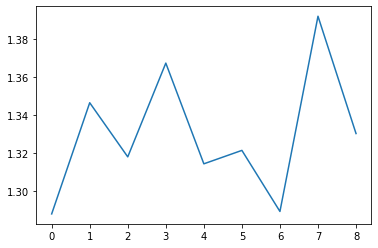

In [145]:
import seaborn
print(loss_values[0])
#loss_values = [i[0] for i in loss_values]
loss = []
for i in loss_values:
    loss.append(float(i))
print(np.arange(len(loss_values)))
seaborn.lineplot(np.arange(len(loss_values)), loss)


In [134]:
num_of_iteration = 10000
wins = 0
draws = 0
loses = 0
for i in range(num_of_iteration):
    game.reset()
    while not game.is_done():
        make_move(game, agent1)
        if game.is_done():
            break
        move = random_policy(game.board, '')
        new_state, reward, is_done, _ = game.step(move)

    wins += game.current_score[0]
    loses += game.current_score[1]
    if game.current_score == (0,0):
        draws += 1